In [1]:
import os
import re
import sklearn
import numpy as np
import pandas as pd
from wombat.engine import ml_model
from wombat.engine import parse_input_description as parse_title
from wombat.models import Item
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from wombat.models import dbsession, engine, ItemType, ItemAdjective
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,12)

In [39]:
df = ml_model.canonical_df
# split data into train and test group
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

# copy of train before we delete the 'rent_per_week' and 'title' field. We want title 
# we will need these things before we make dummy variables
df_full_training = df[df['is_train']==True]
df_full_test = df[df['is_train']==False]

# get one-hot columns for brands 
dummy_brands = pd.get_dummies(df['brand'])
df = pd.concat([df, dummy_brands], axis = 1)

df = df.drop('brand', axis = 1)

# get one-hot columns for item_types
dummified_items = pd.get_dummies(df['item_type'])
df = pd.concat([df, dummified_items], axis = 1)
df = df.drop('item_type', axis = 1)

In [3]:
# get list of adjective features form database
features_adj = [f.name for f in dbsession.query(ItemAdjective).all()]
item_types   = [item.name for item in dbsession.query(ItemType).all()]

tokenized_titles = []
for title in df['title']:
    parse_title.create_one_hot_row_adj(title, features_adj)
    tokenized_titles.append(parse_title.create_one_hot_row_adj(title, features_adj))
df_adj = pd.DataFrame(tokenized_titles, columns = features_adj)

features_adj = [f.name for f in dbsession.query(ItemAdjective).all()]

item_types   = [item.name for item in dbsession.query(ItemType).all()]

tokenized_titles = []
for text_array in df[['title', 'description']].values:
    try:
        text = ' '.join(text_array)
    except TypeError:
        text = title
    #parse_title.create_one_hot_row_adj(text, features_adj)
    tokenized_titles.append(parse_title.create_one_hot_row_adj(text, features_adj))
df_adj = pd.DataFrame(tokenized_titles, columns = features_adj)

In [40]:
df = pd.concat([df_brands, df_adj], axis = 1)

In [41]:
features = df.columns.drop(['rent_per_week', 'title', 'cost', 'is_train', 'description']) # just column names
train, test = df[df['is_train']==True], df[df['is_train']==False]
train.columns

Index(['title', 'cost', 'rent_per_week', 'description', 'is_train',
       '  Dolce & Gabbana', ' Adrianna Papell', ' Alexia Admor',
       ' Amanda Uprichard', ' Basix II',
       ...
       'gala', 'runway', 'ball', 'costume', 'iconic', 'cavier', 'peacock',
       'florence', 'mermaid', 'jersey'],
      dtype='object', length=1877)

In [20]:
y = train['rent_per_week']
#print("Shape of test df: {}".format(test.shape))
#print('Number of observations in the test data: {}'.format(df_full_test.shape))
from sklearn import svm, linear_model

#clf = svm.SVR() # didn't work. Predicted 43 for everything
clf = RandomForestRegressor(n_jobs=2)
clf.fit(train[features], train['rent_per_week'])
rfr_predicted = clf.predict(test[features])
#reg = linear_model.LinearRegression() # total crap
#reg = linear_model.Ridge(alpha = .5) # comparable to rfr but much faster to compute
#reg = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0]) # comparable to rfr 
#reg = linear_model.Lasso(alpha = 0.1)
#reg = linear_model.ElasticNet(alpha=0.1) # comparable to rfr 
#reg = linear_model.RANSACRegressor(linear_model.LinearRegression()) # slow, did not finish, uses lots of cpu
#reg = linear_model.TheilSenRegressor() # slow, did not finish, uses lots of cpu

#reg = linear_model.HuberRegressor() # slow, did not finish, uses lots of cpu

#reg.fit(train[features], train['rent_per_week'])
#rfr_predicted = reg.predict(test[features])

model_dir = '/home/patrick/Dropbox/insight/wombat/wombat/engine/stat_model_pickles'
model_path = os.path.join(model_dir, 'rfr_v0.1_no_adj.pkl')
joblib.dump(reg, model_path)
#call this with: clf = joblib.load('huber_v0.1.pkl')
#rfr_predicted

['/home/patrick/Dropbox/insight/wombat/wombat/engine/stat_model_pickles/rfr_v0.1_no_adj.pkl']

Coefficients:  [ 0.22794437]
Mean squared error: 268.39
Variance score: 0.18


/home/patrick/.virtualenvs/stylelend/lib/python3.5/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/patrick/.virtualenvs/stylelend/lib/python3.5/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,brand,item_type,title,error,description
1306,Chloe,dresses,Chloe Yellow Dress,478.000000,Chloe SS/15 runway yellow silk dress.\nVibrant...
5656,Michael Kors,dresses,Cosmo Orange Gown,440.000000,Feel special when you step into this silk godd...
5285,ddsfsd,dresses,sadfsdf vdesd,380.000000,dsfdsf
5623,Carolina Herrera,dresses,Stunning Gold & Black Ombre Gown,376.500000,Want to be the center of attention at the next...
5311,Any,dresses,Prom dresses,338.000000,Sexy cute beautiful and very unique
4520,Kristi Vosbeck,dresses,Ombre Petals,326.822100,Ombre ruffle skirt gown.
1892,Chanel,outerwear,Kate Middleton Coat,307.558333,Luxury Chanel silk coat with amazing sequins &...
4832,Jason Wu,dresses,Woo Me,305.632690,This dress perfectly combines lace and leather...
3256,Zac Posen,dresses,Full Skirted Cocktail Dress,299.445419,wwe
560,Burberry,dresses,Sheer Double Layer Flower Dress,274.660556,A double layer dress with a sheer and flower o...


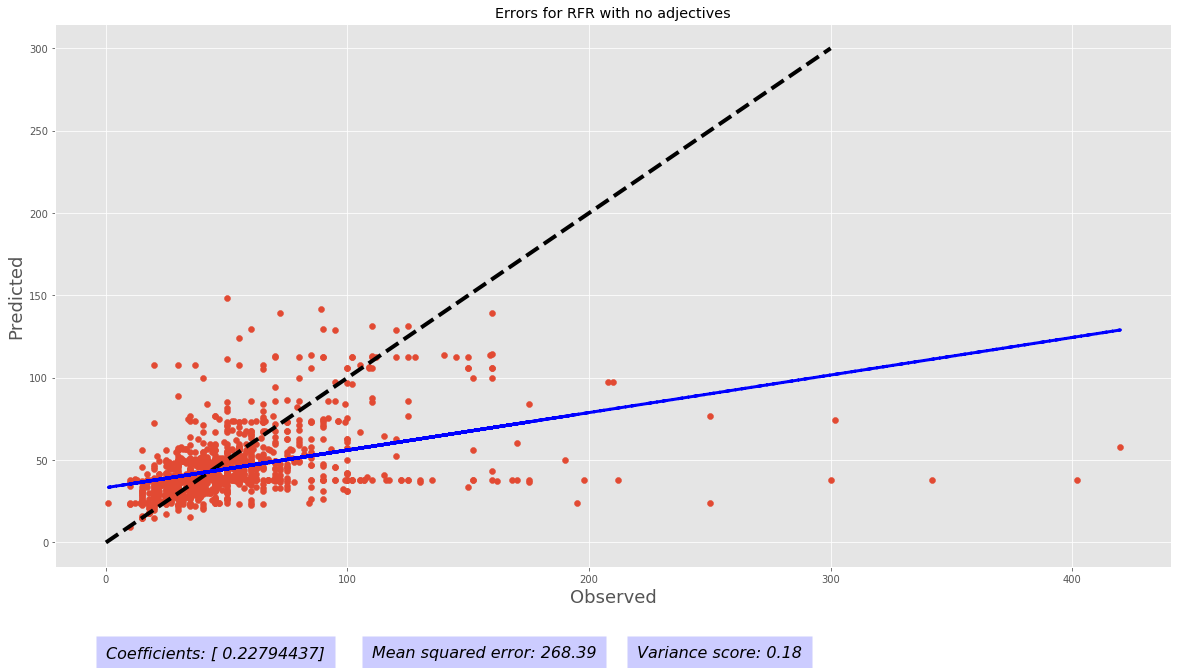

In [25]:
from sklearn import linear_model

# Create linear regression object for predicted vs measured
reg = linear_model.LinearRegression()

x = test['rent_per_week'].values.reshape(-1,1)
y = np.array(rfr_predicted)

# Train the model using the training sets
reg.fit(x, y)
# The coefficients
print('Coefficients: ', reg.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((reg.predict(x) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % reg.score(x, y))

# Plot outputs
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(x = test['rent_per_week'], y = rfr_predicted)
#stopping_value = np.minimum(test['rent_per_week'].max, np.maximum(rfr_predicted))
stopping_value = 300
ax.plot([0, stopping_value], [0, stopping_value], 'k--', lw=4)
ax.set_title('Errors for RFR with no adjectives')
ax.set_xlabel('Observed', fontsize=18)
ax.set_ylabel('Predicted', fontsize=18)
ax.plot(x, reg.predict(x), 'k--', color='blue', linewidth=3)

ax.text(0, -70, 'Coefficients: {}'.format(reg.coef_), style='italic', fontsize=16,
        bbox={'facecolor':'blue', 'alpha':0.2, 'pad':10})
ax.text(110, -70, "Mean squared error: %.2f"
      % np.mean((reg.predict(x) - y) ** 2), style='italic', fontsize=16,
        bbox={'facecolor':'blue', 'alpha':0.2, 'pad':10})
ax.text(220, -70, 'Variance score: %.2f' % reg.score(x, y), style='italic', fontsize=16,
        bbox={'facecolor':'blue', 'alpha':0.2, 'pad':10})

x = test['rent_per_week']
df_full_test['predicted_rent'] = rfr_predicted
df_full_test['error'] = df_full_test[['rent_per_week', 'predicted_rent']].sum(axis=1)
df_full_test.loc[df_full_test['error']>200][['brand', 'item_type', 'title', 'error', 'description']].sort_values('error', ascending = 0)

In [130]:
 # make plotly plot
import plotly.plotly as py
import plotly.graph_objs as go

brands = df_full_training['brand'].values
item_types = df_full_training['item_type'].values
titles = df_full_training['title'].values
labels = []
for i in list(range(0, len(brands))):
    labels.append("{}, {}, {}".format(brands[i], item_types[i], titles[i]))

data = [
    go.Scatter(
        x=test['rent_per_week'],
        y=rfr_predicted,
        mode='markers',
        text=labels
    )
]
layout = go.Layout(
    title='Measured vs Predicted outcomes using Random Forest model'
)
fig = go.Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='meas-v-pred-rfr-2017-06-12')

Coefficients: 
 [ 0.27941375]
Mean squared error: 362.16
Variance score: 0.18


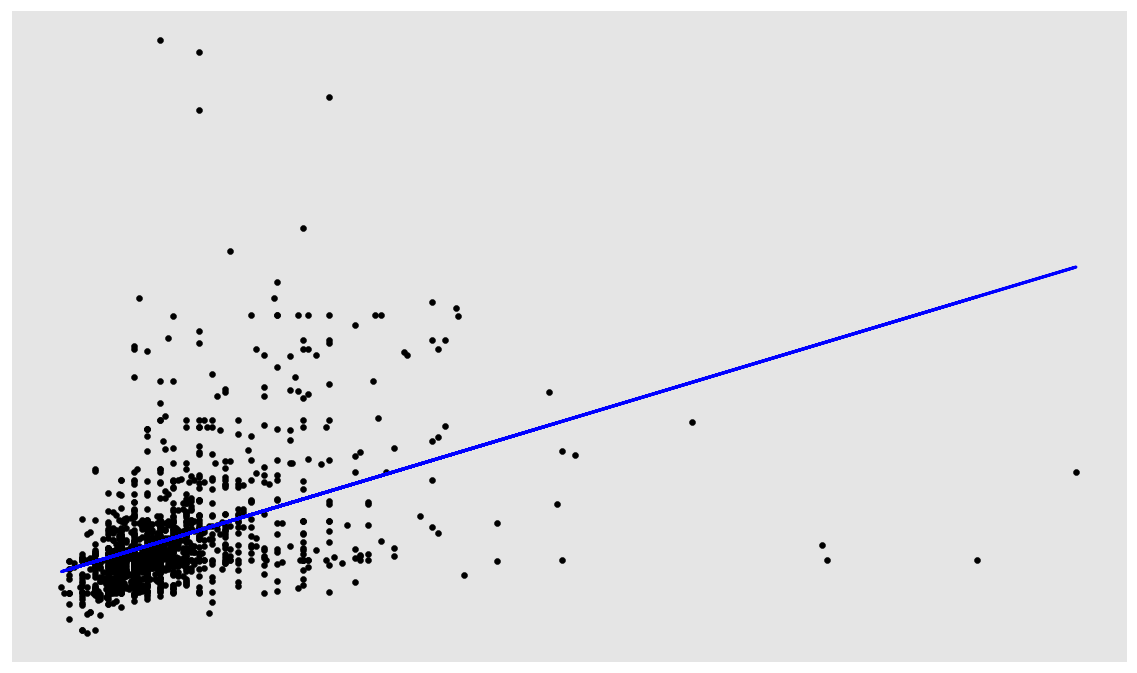

In [131]:
from sklearn import linear_model
# Create linear regression object
reg = linear_model.LinearRegression()

x = test['rent_per_week'].values.reshape(-1,1)
y = np.array(rfr_predicted)

# Train the model using the training sets
reg.fit(x, y)
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((reg.predict(x) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % reg.score(x, y))

# Plot outputs
plt.scatter(x, y,  color='black')
plt.plot(x, reg.predict(x), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()